# People tutorial-1

An image/video footage can be divided into different elements to get deeper insights.

The objective is to remove everything except the objects of interest to understand their actions/behavior. The chosen object class here is people.

This tutorial deals with removing everything but people from an image, so the output is people on a blank background.

This can be achieved by applying the idea of segmentation. Semantic Segmentation is an image analysis task in which each pixel of the image is classified into a class.

More information on segmentation can be found here: https://www.learnopencv.com/image-segmentation/

We will use pre-trained models. Fully Convolutional Network (FCN) and DeepLab v3 are famous models for semantic segmentation.

PyTorch provides a few pre-trained segmentation models (with Resnet backbone) which are trained on COCO dataset: https://pytorch.org/docs/stable/torchvision/models.html#semantic-segmentation

Now, let's delve into the code.

The first step is to load the necessary libraries:

***Torchvision*** package consists of popular datasets, model architectures, and common image transformations for computer vision.

***PIL*** is the Python Imaging Library which provides the python interpreter with image editing capabilities. The ***Image*** module provides a set of emthods for different operations on images.

***NumPy*** is a python library that supports large and multi-dimensional matrix operations.

***Matplotlib*** is a plotting library.

In [0]:
import torch
import torchvision.transforms as T
from torchvision import models

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

Loading a pre-trained model is quite simple.

The ***pretrained=True*** flag will download the model if it is not already downloaded.

The ***.eval()*** method will load it in inference mode. Since, we don't have to train the model, we can load it in evaluation/inference mode.

In [0]:
fcn_model = models.segmentation.fcn_resnet101(pretrained=True).eval()

Load the image and display it.

The image dimensions will be (W, H) where W is the width of the image and H is the height

NOTE: If we are using Google Colab, either we can directly upload the images or use ***wget*** to get the images from an online link.

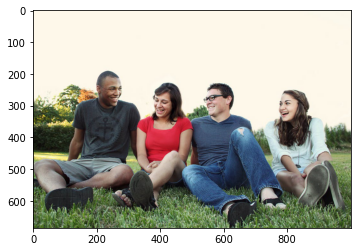

Image dimensions: (1000, 685)


In [5]:
img = Image.open('./img2.jpeg')
plt.imshow(img);
plt.show()

print('Image dimensions:', img.size)

We need to get the image into the right format before feeding it into the model. So, we need to pre-process it. Torchvision has many useful functions. One of them is Transforms which is used to pre-process images. T.Compose is a function that takes in a list in which each element is of transforms type and it returns an object through which we can pass batches of images and all the required transforms will be applied to the images.

In this case, two transformations are used: (1) Image is converted to Tensor format - all the pixel-values will be scaled to a range of [0,1] instead of the original range [0,255]. (2) Then it is normalized with the ImageNet specific values of mean and standard deviation. We can use .Resize() function if we want to resize the image.

After processing, the transformed image will have the dimensions torch.Size([C, H, W]) - C is the number of channels, H is the height, W is the width. The processed image is of torch tensor type, so torch.Size() is seen in the output.

In [6]:
trf = T.Compose([T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
processed_image = trf(img)

print('Transformed Image dimensions:', processed_image.size())

Transformed Image dimensions: torch.Size([3, 685, 1000])


The expected input dimension for the model is [N x C x H x W] where N is the batch size (number of samples to be passed through the network in one iteration). Here, we are dealing with a single image, so N = 1. The image is unsqueezed so that it becomes [1 x C x H x W] from [C x H x W]. The model expects a 3-channel RGB image, so C should be 3.

In [7]:
input_image = processed_image.unsqueeze(0)

print('Input image dimensions:', input_image.size())

Input image dimensions: torch.Size([1, 3, 685, 1000])


Now that we have the processed input image ready, let's feed it to the network and get the output.

The output of the model will have dimensions [N x Co x Ho x Wo]. N is same as that of input. Co is the number of segmentation classes. Ho and Wo will generally have the same value as that of H and W, but not necessary.

The output of torchvision segmentation models is an OrderedDict and not a torch.Tensor. The OrderedDict has a key 'out' which holds the output and it's corresponding value has the shape [N x Co x Ho x Wo].

In [8]:
output_image = fcn_model(input_image)['out']

print('Output image dimensions:', output_image.size())

Output image dimensions: torch.Size([1, 21, 685, 1000])


The fully convolutional model was trained on 21 classes, so Co = 21.

Now, we need to convert this output of 21 channels into a 2D image or a 1 channel image, where each pixel of that image corresponds to a single class.

The transformed output should be [Ho x Wo]. To transform the output from [1 x 21 x Ho x Wo] to [Ho x Wo], we have to use squeeze() function to get [21 x Ho x Wo]. At each pixel location (x,y), there are 21 values corresponding to the scores for each of the 21 classes. We take the index of the maximum score and assign it to the corresponding pixel location. So, the transformed output will have values in the range [0,20].

In [9]:
output_2D = torch.argmax(output_image.squeeze(), dim=0).detach().numpy()

print(output_2D.shape)

(685, 1000)


Torch tensors have gradients attached. They are required for backpropagation and updating the network parameters. For evaluation purposes, we don't require gradients to the tensors, so we use ***.detach()*** method. And we use ***.numpy()*** method to convert the torch tensor to numpy array/matrix for decode operations.

The next step is to take the output 2D image and convert it into a segmentation map where each class label is converted into a RGB color and for clear visualization.

We use ***decode_segmap*** function for this task which takes the original image and the output 2D image (numpy format) as inputs.

The variable *label_colors* stores the colors for each of the classes according to their index. So, the color for the first class which is background is stored at the 0th index of the label_colors list. The second class, which is aeroplane, is stored at index 1. The third class, bicycle, is stored at index 2 and so on.

Next, we have to create an RGB image from the 2D image we have. So, we create an empty 2D matrices for all 3 channels.

***np.zeros_like(image)*** creates a numpy array with the same dimensions as that of ***image***.

Now, we loop over each class color we stored in *label_colors* and we get the indexes in the image where that particular class label is present. Then for each channel, we put its corresponding color to those pixels where that class label is present.

Finally, we stack the 3 separate channels to form a RGB segmentation map. This segmentation map gives information about all the 21 classes.

Our object of interest is people. **15** is the index for people in the model's output. We loop over each pixel in the output 2D image and whereever the value is not equal to **15**, we set it to 0 - so that any pixel which doesn't correspond to people is set to black color (as background).

The decode_segmap function returns the segmentation map and transformed image with only people.

NOTE: ***.size*** parameter on a PIL image gives the output as (W, H) and ***.shape*** parameter on a numpy array gives the output as (H, W), where W is the width and H is the height. So, we need to do the calculations accordingly.

In [0]:
def decode_segmap(image_pil, image_np, nc=21):
   
    label_colors = np.array([
              # 0=background,   1=aeroplane, 2=bicycle,   3=bird,        4=boat,      5=bottle
               (0, 0, 0),      (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),

              # 6=bus,         7=car,           8=cat,      9=chair,     10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),

              # 11=dining table,  12=dog,       13=horse,      14=motorbike,   15=person
               (192, 128, 0),    (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),

              # 16=potted plant,  17=sheep,     18=sofa,     19=train,      20=tv/monitor
               (0, 64, 0),       (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
               ])
 
    r = np.zeros_like(image_np).astype(np.uint8)
    g = np.zeros_like(image_np).astype(np.uint8)
    b = np.zeros_like(image_np).astype(np.uint8)
   
    for l in range(0, nc):
      # gets the indices
    	idx = (image_np == l)
     
      # puts the label_colors values at those indices
    	r[idx] = label_colors[l, 0]
    	g[idx] = label_colors[l, 1]
    	b[idx] = label_colors[l, 2]
     
    rgb = np.stack([r, g, b], axis=2)

    w,h = image_pil.size
    for x in range(w):
      for y in range(h):
        if(image_np[y,x] != 15):
          image_pil.putpixel((x,y),0)

    return rgb, image_pil

Let's run the function to view the segmentation map and the image with only people.

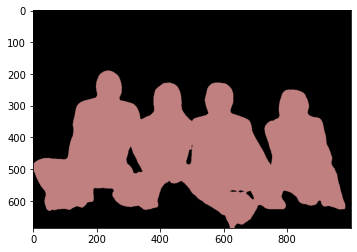

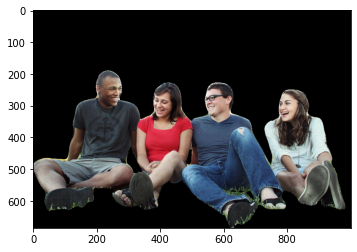

In [12]:
seg_map, img_poeple = decode_segmap(img, output_2D)
plt.imshow(seg_map);
plt.show()
plt.imshow(img_poeple);
plt.show()

For simplicity, we can put all the above operations into a single function.

The ***segment*** function takes the original image, transforms it into the required input format for the network, gets the output image, converts it into a 2D image of class labels, obtains the segmatation map and the image with only people using ***decode_segmap*** function and displays them.

In [0]:
def segment(net, path):
    img = Image.open(path)
    plt.imshow(img);
    plt.show()
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    img_np = torch.argmax(out.squeeze(), dim=0).detach().numpy()
    seg_map, img_poeple = decode_segmap(img, img_np)
    plt.imshow(seg_map);
    plt.show()
    plt.imshow(img_poeple);
    plt.show()

Run the ***segment*** function with the model and the path to the image file

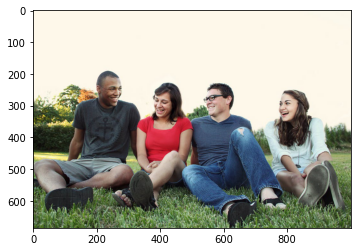

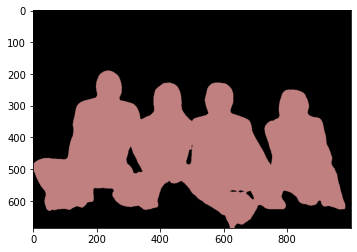

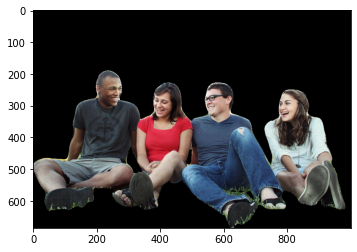

In [14]:
segment(fcn_model, './img2.jpeg')